<a href="https://colab.research.google.com/github/Kinashi-Naoto/chem/blob/master/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lithium ion battery SOC予測コンペチュートリアル
### チュートリアルでやること
このチュートリアルでは、簡易的なディープニューラルネットワークのモデルでSOCを予測し、submission.csvを作成するまでを行います。  
提出までの流れを説明するのが目的です。

### ディレクトリ構造
以下のような構造が前提です。  
カレントディレクトリはcodeです。  
チュートリアルの副作用としてカレントディレクトリにsubmission.csvが作成されます。  
```
├── code
│   ├── submission.csv ← チュートリアルの副作用
│   └── tutorial.ipynb
└── data
    ├── data_explanation.xlsx
    ├── sample_submission.csv
    ├── test.csv
    └── train
        ├── n10degC_Cycle_1_Pan18650PF.csv
        ├── n10degC_NN_Pan18650PF.csv
        ├── n10degC_US06_Pan18650PF.csv
        ├── n20degC_Cycle_1_Pan18650PF.csv
        ├── n20degC_NN_Pan18650PF.csv
        ├── n20degC_US06_Pan18650PF.csv
        ├── p0degC_Cycle_1_Pan18650PF.csv
        ├── p0degC_NN_Pan18650PF.csv
        ├── p0degC_US06_Pan18650PF.csv
        ├── p10degC_Cycle_1_Pan18650PF.csv
        ├── p10degC_NN_Pan18650PF.csv
        ├── p10degC_US06_Pan18650PF.csv
        ├── p25degC_Cycle_1_Pan18650PF.csv
        ├── p25degC_NN_Pan18650PF.csv
        └── p25degC_US06_Pan18650PF.csv
```



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection
from sklearn import preprocessing

from tqdm.notebook import tqdm

sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=False, rc=None)
np.set_printoptions(precision=6,suppress=True)

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

## Trainデータのチェック
* 本コンペのデータは、自動車の運転をシミュレートし観測されました。
* 運転のシナリオごとに、csvファイルが存在しファイル名にはUS06などの名前がついておりますがこれは運転シナリオの名前を意味します。
* 運転のシナリオは[ここ](https://dieselnet.com/standards/cycles/udds.php)が参考になります。
* また周囲温度条件によってもcsvが別れております

In [ ]:
from glob import glob

drivecycle_csvs = glob("../data/train/*.csv")
drivecycle_csvs.sort()

In [ ]:
train_dfs = [pd.read_csv(path) for path in drivecycle_csvs]

In [ ]:
train_dfs[0]

,TimeStamp,Voltage,Current,Ah,Wh,Power,Battery_Temp_degC,Time,Chamber_Temp_degC,SOC,Drive Cycle
0,6/10/2017 11:25:41 AM,4.10596,-1.80146,-0.00005,NaN,-7.396723,-10.158136,0.000000,-10,99.998276,Cycle_1
1,6/10/2017 11:25:41 AM,4.01524,-1.84964,-0.00010,NaN,-7.426749,-10.158136,0.102001,-10,99.996552,Cycle_1
2,6/10/2017 11:25:41 AM,3.95799,-1.88639,-0.00015,NaN,-7.466313,-10.158136,0.197002,-10,99.994828,Cycle_1
3,6/10/2017 11:25:41 AM,3.90973,-1.91824,-0.00021,NaN,-7.499800,-10.158136,0.300008,-10,99.992759,Cycle_1
4,6/10/2017 11:25:41 AM,3.86920,-1.94519,-0.00026,NaN,-7.526329,-10.158136,0.398006,-10,99.991034,Cycle_1
...,...,...,...,...,...,...,...,...,...,...,...
57229,6/10/2017 1:01:15 PM,3.13705,-0.34625,-2.02998,NaN,-1.086204,-4.953044,5734.232003,-10,30.000690,Cycle_1
57230,6/10/2017 1:01:15 PM,3.14863,-0.34380,-2.02999,NaN,-1.082499,-4.953044,5734.329005,-10,30.000345,Cycle_1
57231,6/10/2017 1:01:15 PM,3.15828,-0.34298,-2.03000,NaN,-1.083227,-4.953044,5734.431006,-10,30.000000,Cycle_1
57232,6/10/2017 1:01:16 PM,3.16536,-0.34135,-2.03001,NaN,-1.080496,-4.953044,5734.525001,-10,29.999655,Cycle_1


In [ ]:
sample_submission = pd.read_csv("../data/sample_submission.csv")

In [ ]:
sample_submission

,ID,SOC
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2618958,2618958,0
2618959,2618959,0
2618960,2618960,0
2618961,2618961,0


In [ ]:
test_df = pd.read_csv("../data/test.csv")
test_df

,ID,TimeStamp,Voltage,Current,Power,Battery_Temp_degC,Time,Chamber_Temp_degC,Drive Cycle
0,0,6/24/2017 7:29:56 PM,4.11690,-1.50911,-6.212855,-20.308876,0.000000,-20,Cycle_3
1,1,6/24/2017 7:29:56 PM,3.99144,-1.60057,-6.388579,-20.308876,0.104003,-20,Cycle_3
2,2,6/24/2017 7:29:56 PM,3.90330,-1.66182,-6.486582,-20.308876,0.202001,-20,Cycle_3
3,3,6/24/2017 7:29:56 PM,3.84861,-1.69694,-6.530860,-20.308876,0.299998,-20,Cycle_3
4,4,6/24/2017 7:29:56 PM,3.79586,-1.72797,-6.559132,-20.308876,0.399998,-20,Cycle_3
...,...,...,...,...,...,...,...,...,...
2618958,2618958,6/12/2017 8:15:12 AM,3.12225,-1.46420,-4.571598,-7.870318,17814.272998,-10,UDDS
2618959,2618959,6/12/2017 8:15:13 AM,3.11968,-1.46583,-4.572921,-7.870318,17814.372002,-10,UDDS
2618960,2618960,6/12/2017 8:15:13 AM,3.11711,-1.46747,-4.574265,-7.870318,17814.472997,-10,UDDS
2618961,2618961,6/12/2017 8:15:13 AM,3.11711,-1.46747,-4.574265,-7.870318,17814.491997,-10,UDDS


## 各ドライブサイクルのSOC

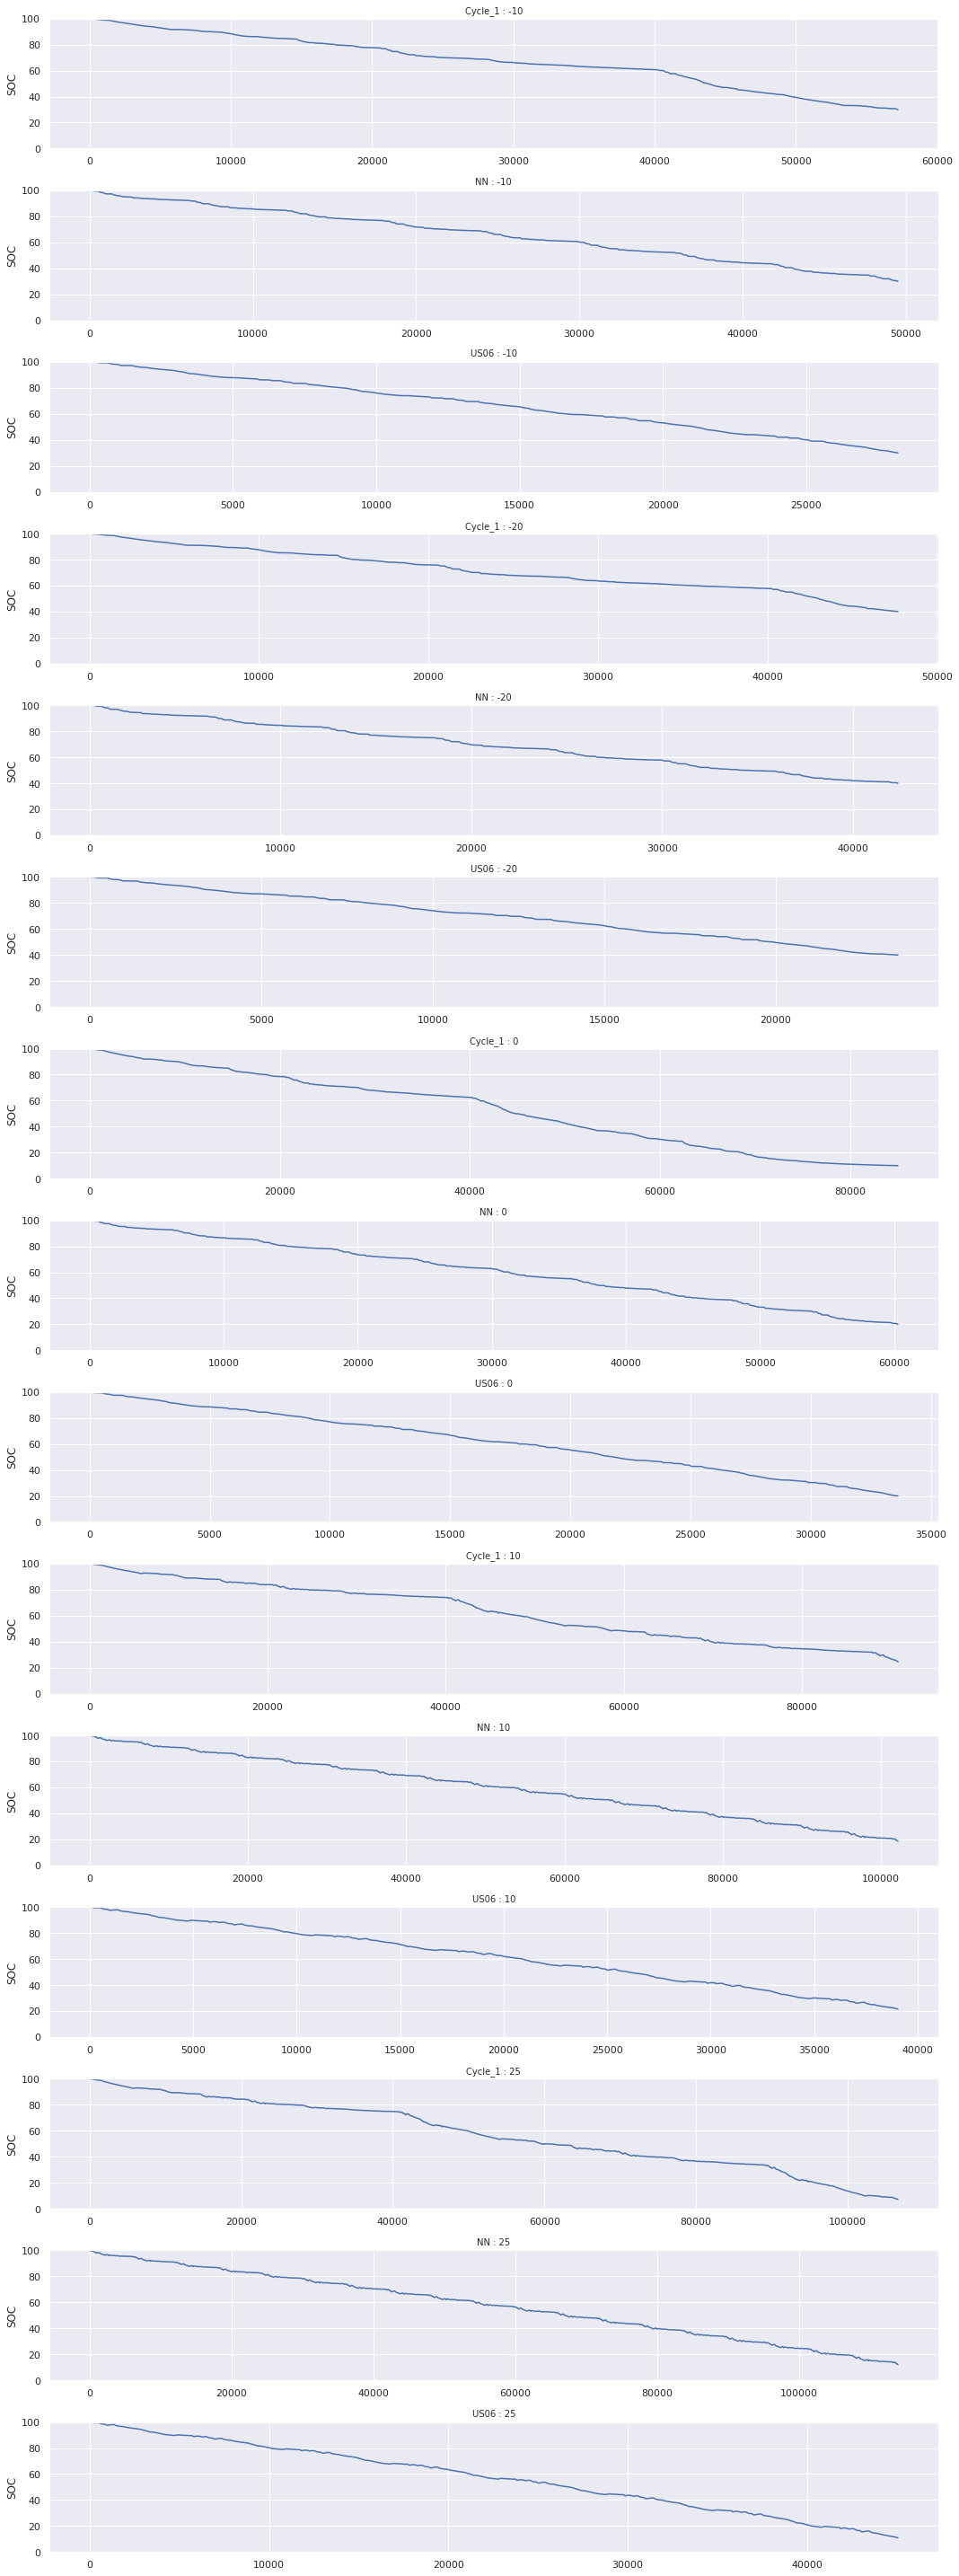

In [ ]:
fig = plt.figure(figsize=(15,40))

length = len(train_dfs)

for i, data in enumerate(train_dfs):

    plt.subplot(length, 1, i+1)
    graph_title = data["Drive Cycle"].iloc[0] +" : "+str(data["Chamber_Temp_degC"].iloc[0])
    g = sns.lineplot(data=data[:],x=data.index[:],y="SOC")
    g.set_title(f'{graph_title}', fontsize=10)
    plt.ylim(0,100)

plt.tight_layout()
plt.show()

## モデルの実装
kerasで簡易的なDNNを組みます

In [ ]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM

from keras.layers.core import Dense, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.optimizers import Adam, SGD
from keras.callbacks import LearningRateScheduler
import keras.callbacks
import tensorflow as tf
import os.path

from sklearn.metrics import mean_squared_error

In [ ]:
def build_dnn_model(input_data, output_size, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam', learning_rate=0.1):
    
    model = Sequential()
    model.add(Dense(256, input_dim=input_data.shape[1], activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(output_size))

    model.compile(loss=loss, optimizer=optimizer)
    
    return model

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(10, 5))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

    fig.show()

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(
        intra_op_parallelism_threads=1,
        inter_op_parallelism_threads=1
    )
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)

seed_everything(42)

In [ ]:
test_size = 0.2
zero_base = True

epochs = 100  
batch_size = 128
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

## 訓練データとバリデーションデータ
* 温度条件:25℃、Drive Cycle:US06を訓練データ
* 温度条件:25℃、Drive Cycle:Cycle_1をバリデーションデータ  
に設定

In [ ]:
df_25_US06 = pd.read_csv("../data/train/p25degC_US06_Pan18650PF.csv")
df_25_Cycle_1 = pd.read_csv('../data/train/p25degC_Cycle_1_Pan18650PF.csv')

## モデルにinputするためのデータ
* 電圧、電流、バッテリー温度を説明変数とする
* 電流、電圧、バッテリー温度を平滑化するために、移動平均を取る
* 移動平均のwindow size文、NaNになるためそこの箇所は移動平均を取らずにそのまま埋める

In [ ]:
def get_dataset_for_DNN(df_, window=400, sc=None, feature_col=None, target_col=None):

    df = df_.copy()

    ### 移動平均
    df['V_ave'] = df['Voltage'].rolling(window).mean()
    df['I_ave'] = df['Current'].rolling(window).mean()
    df['T_ave'] = df['Battery_Temp_degC'].rolling(window).mean()
    ### 最初のwindowサイズまでは移動平均をとるとNaNになるので、値をそのままとる
    df['V_ave'].iloc[:window] = df['Voltage'].iloc[:window]
    df['I_ave'].iloc[:window] = df['Current'].iloc[:window]
    df['T_ave'].iloc[:window] = df['Battery_Temp_degC'].iloc[:window]

    if sc:
        df.loc[:,feature_col] = sc.fit_transform(df.loc[:,feature_col])
    
    X = df[feature_col].to_numpy()

    if target_col:
        y = df[target_col].to_numpy()
        return X,y
    else:
        return X

In [ ]:
sc = StandardScaler()
window_len = 400

feature_col = ['Voltage', 'V_ave', 'I_ave', 'T_ave']
target_col = ['SOC']

X_train, y_train = get_dataset_for_DNN(df_25_US06, window=window_len, sc=sc, feature_col=feature_col,target_col=target_col)
X_val, y_val = get_dataset_for_DNN(df_25_Cycle_1, window=window_len, sc=sc, feature_col=feature_col,target_col=target_col)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
epochs = 50
model_dnn = build_dnn_model(X_train, output_size=1,dropout=dropout,loss=loss,optimizer=optimizer)
history = model_dnn.fit( X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True )

Epoch 1/50
353/353 [==============================] - 22s 6ms/step - loss: 2791.1157
Epoch 2/50
353/353 [==============================] - 2s 6ms/step - loss: 75.9149
Epoch 3/50
353/353 [==============================] - 2s 6ms/step - loss: 26.5536
Epoch 4/50
353/353 [==============================] - 2s 6ms/step - loss: 23.9034
Epoch 5/50
353/353 [==============================] - 2s 6ms/step - loss: 23.0028
Epoch 6/50
353/353 [==============================] - 2s 5ms/step - loss: 21.1822
Epoch 7/50
353/353 [==============================] - 2s 5ms/step - loss: 22.1664
Epoch 8/50
353/353 [==============================] - 2s 6ms/step - loss: 20.1527
Epoch 9/50
353/353 [==============================] - 2s 6ms/step - loss: 17.4465
Epoch 10/50
353/353 [==============================] - 2s 6ms/step - loss: 18.3628
Epoch 11/50
353/353 [==============================] - 2s 6ms/step - loss: 17.8340
Epoch 12/50
353/353 [==============================] - 2s 6ms/step - loss: 16.0473
Epoch 13/5

### バリデーションデータに対するprediction

4.158156354080969


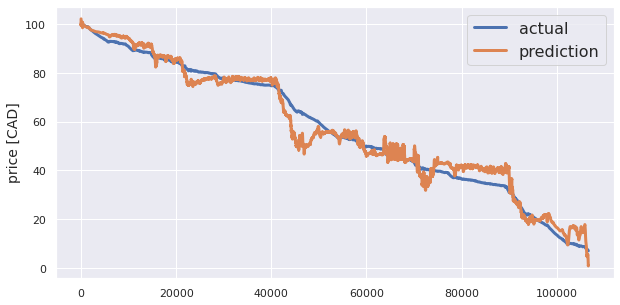

In [ ]:
preds_val = model_dnn.predict(X_val).squeeze()
line_plot(y_val, preds_val, 'actual', 'prediction', lw=3)

print(np.sqrt(mean_squared_error(y_val, preds_val)))

## Testデータに対してprediction

In [ ]:
test_df

,ID,TimeStamp,Voltage,Current,Power,Battery_Temp_degC,Time,Chamber_Temp_degC,Drive Cycle
0,0,6/24/2017 7:29:56 PM,4.11690,-1.50911,-6.212855,-20.308876,0.000000,-20,Cycle_3
1,1,6/24/2017 7:29:56 PM,3.99144,-1.60057,-6.388579,-20.308876,0.104003,-20,Cycle_3
2,2,6/24/2017 7:29:56 PM,3.90330,-1.66182,-6.486582,-20.308876,0.202001,-20,Cycle_3
3,3,6/24/2017 7:29:56 PM,3.84861,-1.69694,-6.530860,-20.308876,0.299998,-20,Cycle_3
4,4,6/24/2017 7:29:56 PM,3.79586,-1.72797,-6.559132,-20.308876,0.399998,-20,Cycle_3
...,...,...,...,...,...,...,...,...,...
2618958,2618958,6/12/2017 8:15:12 AM,3.12225,-1.46420,-4.571598,-7.870318,17814.272998,-10,UDDS
2618959,2618959,6/12/2017 8:15:13 AM,3.11968,-1.46583,-4.572921,-7.870318,17814.372002,-10,UDDS
2618960,2618960,6/12/2017 8:15:13 AM,3.11711,-1.46747,-4.574265,-7.870318,17814.472997,-10,UDDS
2618961,2618961,6/12/2017 8:15:13 AM,3.11711,-1.46747,-4.574265,-7.870318,17814.491997,-10,UDDS


## Testデータから温度条件、Drive CycleごとにDataFrameを作り直す
* Test.csvはTrainと違い、温度条件、Drive Cycleごとにcsvが別れていない
* 1Cycleにつきpredictionを行いたいので、DataFrameを作り直す

In [ ]:
test_df["Cycles"] = test_df["Chamber_Temp_degC"].astype(str)+"_"+test_df["Drive Cycle"]
U_Cycles = test_df["Cycles"].unique()
print(U_Cycles)
test_dfs = [test_df[test_df["Cycles"]==cycle] for cycle in U_Cycles]

['-20_Cycle_3' '-10_Cycle_4' '25_Cycle_2' '-20_Cycle_4' '-10_HWFET'
 '10_UDDS' '0_Cycle_3' '-10_LA92' '-20_LA92' '0_UDDS' '10_LA92'
 '0_Cycle_2' '0_Cycle_4' '10_Cycle_2' '25_UDDS' '10_Cycle_4' '25_LA92'
 '-20_HWFET' '-10_Cycle_2' '-20_Cycle_2' '10_Cycle_3' '-10_Cycle_3'
 '0_LA92' '25_HWFET' '10_HWFET' '25_Cycle_3' '-20_UDDS' '25_Cycle_4'
 '0_HWFET' '-10_UDDS']


## Testデータに対するprediction

In [ ]:
for i in range(len(test_dfs)):
    X_test = get_dataset_for_DNN(test_dfs[i], window=window_len, sc=sc, feature_col=feature_col)
    preds = model_dnn.predict(X_test).squeeze()

    sample_submission.iloc[test_dfs[i].index,1] = preds

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

In [ ]:
sample_submission.to_csv("./submission.csv", index=False)

### EOF